In [1]:
import pandas as pd
import numpy as np #must be 1.26.4 on python 3.12
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [2]:
df = pd.read_csv('/Users/danayou/Desktop/DS-Case-Study/data/customer.csv')
df = df.head(500000)

In [3]:
num_users = df['CUSTOMER_ID'].nunique()
num_items = df['STOCK_CODE'].nunique()
print(f"Number of unique users: {num_users}")
print(f"Number of unique items: {num_items}")

Number of unique users: 2326
Number of unique items: 97403


In [4]:
#Drop zero values in order quantity
df = df[~df['Sales_Order_Quantity'].isin([0.0])]
df.head()

,CUSTOMER_ID,Customer_Master_Account_ID,DATE_KEY,Customer_ShipTo_Addr3,Customer_ShipTo_Addr4,STOCK_CODE,Sales_Order_Quantity,Sales_Order_Item_Price,Sales_Order_Extended_Sale_Amount,Sales_Invoice_Number,Sales_Order,SALES_ORDER_KEY,Sales_Order_Extended_Margin_Amount,Sales_Order_Extended_List_Price_Amount,Cancelled_Flag,Product_Name
0,f65441a4f5d7b872ea428bdc27359061,NaN,03/09/2020,HONOLULU,HI,42f2127c2763a78382243c3f653e3e7e,10.0,26.68,266.80,37e32447f3c8d536f39470c22c4cb9b8,5d889fa0241b7b92e1d02a6c98ff4232,5d889fa0241b7b92e1d02a6c98ff4232,115.80,541.8,NaN,Stainless Steel Glass Beige FoodService Dryer ...
1,b2b8f192051c662865b33e9045b562cd,NaN,03/08/2022,BIDDEFORD,ME,d1f4aa12b9958ac7e8881de4feb119d6,2.0,46.20,92.40,ab4b2aaf42623fc4fb17fa246ff75a80,1c73473568f80cd5b22fd233831803c3,1c73473568f80cd5b22fd233831803c3,15.40,162.0,NaN,Seamless Steel Gray HeatWave Dishwasher Clamp
2,165cb4c8e28d9a7dd63ec58f54e12d49,NaN,03/01/2023,ANCHORAGE,AK,5c3cb6dec6751d4ba5c1426554789e20,4.0,39.00,156.00,776afa276779e00793e2ea00a15f9247,4298cb0e273806987aff733a183f1328,4298cb0e273806987aff733a183f1328,36.00,240.0,NaN,Quiet Polypropylene Copper GastroTech Coffee M...
3,e55c3852248cf8abf61f8eddfb4c81e0,e55c3852248cf8abf61f8eddfb4c81e0,12/01/2021,GRAY,ME,7bc5022dbc074cce52d3b986591d5409,1.0,45.02,45.02,0197caed1f6f4bee63ed787b39c604b0,3997d2293c96fd769389a5a3680387ed,3997d2293c96fd769389a5a3680387ed,8.12,84.0,NaN,Ergonomic Carbon Fiber Bronze BrandC Deep Frye...
4,e55c3852248cf8abf61f8eddfb4c81e0,e55c3852248cf8abf61f8eddfb4c81e0,11/15/2021,GRAY,ME,f1b96ba3745e55ebc58035399b9c1da4,1.0,35.20,35.20,75e8a2d04671f1e4385a49f86403cc80,448b42704b27be4b9594392b86f3f012,448b42704b27be4b9594392b86f3f012,7.04,38.8,NaN,Adjustable Polypropylene Blue BrandA Coffee Ma...


In [5]:
#Remove rows with cancelled orders
df = df.drop(df[df['Cancelled_Flag'] == 'False'].index)
df.head()

,CUSTOMER_ID,Customer_Master_Account_ID,DATE_KEY,Customer_ShipTo_Addr3,Customer_ShipTo_Addr4,STOCK_CODE,Sales_Order_Quantity,Sales_Order_Item_Price,Sales_Order_Extended_Sale_Amount,Sales_Invoice_Number,Sales_Order,SALES_ORDER_KEY,Sales_Order_Extended_Margin_Amount,Sales_Order_Extended_List_Price_Amount,Cancelled_Flag,Product_Name
0,f65441a4f5d7b872ea428bdc27359061,NaN,03/09/2020,HONOLULU,HI,42f2127c2763a78382243c3f653e3e7e,10.0,26.68,266.80,37e32447f3c8d536f39470c22c4cb9b8,5d889fa0241b7b92e1d02a6c98ff4232,5d889fa0241b7b92e1d02a6c98ff4232,115.80,541.8,NaN,Stainless Steel Glass Beige FoodService Dryer ...
1,b2b8f192051c662865b33e9045b562cd,NaN,03/08/2022,BIDDEFORD,ME,d1f4aa12b9958ac7e8881de4feb119d6,2.0,46.20,92.40,ab4b2aaf42623fc4fb17fa246ff75a80,1c73473568f80cd5b22fd233831803c3,1c73473568f80cd5b22fd233831803c3,15.40,162.0,NaN,Seamless Steel Gray HeatWave Dishwasher Clamp
2,165cb4c8e28d9a7dd63ec58f54e12d49,NaN,03/01/2023,ANCHORAGE,AK,5c3cb6dec6751d4ba5c1426554789e20,4.0,39.00,156.00,776afa276779e00793e2ea00a15f9247,4298cb0e273806987aff733a183f1328,4298cb0e273806987aff733a183f1328,36.00,240.0,NaN,Quiet Polypropylene Copper GastroTech Coffee M...
3,e55c3852248cf8abf61f8eddfb4c81e0,e55c3852248cf8abf61f8eddfb4c81e0,12/01/2021,GRAY,ME,7bc5022dbc074cce52d3b986591d5409,1.0,45.02,45.02,0197caed1f6f4bee63ed787b39c604b0,3997d2293c96fd769389a5a3680387ed,3997d2293c96fd769389a5a3680387ed,8.12,84.0,NaN,Ergonomic Carbon Fiber Bronze BrandC Deep Frye...
4,e55c3852248cf8abf61f8eddfb4c81e0,e55c3852248cf8abf61f8eddfb4c81e0,11/15/2021,GRAY,ME,f1b96ba3745e55ebc58035399b9c1da4,1.0,35.20,35.20,75e8a2d04671f1e4385a49f86403cc80,448b42704b27be4b9594392b86f3f012,448b42704b27be4b9594392b86f3f012,7.04,38.8,NaN,Adjustable Polypropylene Blue BrandA Coffee Ma...


In [6]:
#Make column for return quantity
df['Return_Quantity'] = df['Sales_Order_Quantity'].where(df['Sales_Order_Quantity'] < 0)
df['Return_Quantity'] = df['Return_Quantity'].fillna(0)
df.head()

,CUSTOMER_ID,Customer_Master_Account_ID,DATE_KEY,Customer_ShipTo_Addr3,Customer_ShipTo_Addr4,STOCK_CODE,Sales_Order_Quantity,Sales_Order_Item_Price,Sales_Order_Extended_Sale_Amount,Sales_Invoice_Number,Sales_Order,SALES_ORDER_KEY,Sales_Order_Extended_Margin_Amount,Sales_Order_Extended_List_Price_Amount,Cancelled_Flag,Product_Name,Return_Quantity
0,f65441a4f5d7b872ea428bdc27359061,NaN,03/09/2020,HONOLULU,HI,42f2127c2763a78382243c3f653e3e7e,10.0,26.68,266.80,37e32447f3c8d536f39470c22c4cb9b8,5d889fa0241b7b92e1d02a6c98ff4232,5d889fa0241b7b92e1d02a6c98ff4232,115.80,541.8,NaN,Stainless Steel Glass Beige FoodService Dryer ...,0.0
1,b2b8f192051c662865b33e9045b562cd,NaN,03/08/2022,BIDDEFORD,ME,d1f4aa12b9958ac7e8881de4feb119d6,2.0,46.20,92.40,ab4b2aaf42623fc4fb17fa246ff75a80,1c73473568f80cd5b22fd233831803c3,1c73473568f80cd5b22fd233831803c3,15.40,162.0,NaN,Seamless Steel Gray HeatWave Dishwasher Clamp,0.0
2,165cb4c8e28d9a7dd63ec58f54e12d49,NaN,03/01/2023,ANCHORAGE,AK,5c3cb6dec6751d4ba5c1426554789e20,4.0,39.00,156.00,776afa276779e00793e2ea00a15f9247,4298cb0e273806987aff733a183f1328,4298cb0e273806987aff733a183f1328,36.00,240.0,NaN,Quiet Polypropylene Copper GastroTech Coffee M...,0.0
3,e55c3852248cf8abf61f8eddfb4c81e0,e55c3852248cf8abf61f8eddfb4c81e0,12/01/2021,GRAY,ME,7bc5022dbc074cce52d3b986591d5409,1.0,45.02,45.02,0197caed1f6f4bee63ed787b39c604b0,3997d2293c96fd769389a5a3680387ed,3997d2293c96fd769389a5a3680387ed,8.12,84.0,NaN,Ergonomic Carbon Fiber Bronze BrandC Deep Frye...,0.0
4,e55c3852248cf8abf61f8eddfb4c81e0,e55c3852248cf8abf61f8eddfb4c81e0,11/15/2021,GRAY,ME,f1b96ba3745e55ebc58035399b9c1da4,1.0,35.20,35.20,75e8a2d04671f1e4385a49f86403cc80,448b42704b27be4b9594392b86f3f012,448b42704b27be4b9594392b86f3f012,7.04,38.8,NaN,Adjustable Polypropylene Blue BrandA Coffee Ma...,0.0


In [7]:
#Make purchase or return column
df['Purchase_or_Return'] = df['Sales_Order_Quantity'].apply(lambda x: 'Purchase' if x > 0 else 'Return')
df.head()

,CUSTOMER_ID,Customer_Master_Account_ID,DATE_KEY,Customer_ShipTo_Addr3,Customer_ShipTo_Addr4,STOCK_CODE,Sales_Order_Quantity,Sales_Order_Item_Price,Sales_Order_Extended_Sale_Amount,Sales_Invoice_Number,Sales_Order,SALES_ORDER_KEY,Sales_Order_Extended_Margin_Amount,Sales_Order_Extended_List_Price_Amount,Cancelled_Flag,Product_Name,Return_Quantity,Purchase_or_Return
0,f65441a4f5d7b872ea428bdc27359061,NaN,03/09/2020,HONOLULU,HI,42f2127c2763a78382243c3f653e3e7e,10.0,26.68,266.80,37e32447f3c8d536f39470c22c4cb9b8,5d889fa0241b7b92e1d02a6c98ff4232,5d889fa0241b7b92e1d02a6c98ff4232,115.80,541.8,NaN,Stainless Steel Glass Beige FoodService Dryer ...,0.0,Purchase
1,b2b8f192051c662865b33e9045b562cd,NaN,03/08/2022,BIDDEFORD,ME,d1f4aa12b9958ac7e8881de4feb119d6,2.0,46.20,92.40,ab4b2aaf42623fc4fb17fa246ff75a80,1c73473568f80cd5b22fd233831803c3,1c73473568f80cd5b22fd233831803c3,15.40,162.0,NaN,Seamless Steel Gray HeatWave Dishwasher Clamp,0.0,Purchase
2,165cb4c8e28d9a7dd63ec58f54e12d49,NaN,03/01/2023,ANCHORAGE,AK,5c3cb6dec6751d4ba5c1426554789e20,4.0,39.00,156.00,776afa276779e00793e2ea00a15f9247,4298cb0e273806987aff733a183f1328,4298cb0e273806987aff733a183f1328,36.00,240.0,NaN,Quiet Polypropylene Copper GastroTech Coffee M...,0.0,Purchase
3,e55c3852248cf8abf61f8eddfb4c81e0,e55c3852248cf8abf61f8eddfb4c81e0,12/01/2021,GRAY,ME,7bc5022dbc074cce52d3b986591d5409,1.0,45.02,45.02,0197caed1f6f4bee63ed787b39c604b0,3997d2293c96fd769389a5a3680387ed,3997d2293c96fd769389a5a3680387ed,8.12,84.0,NaN,Ergonomic Carbon Fiber Bronze BrandC Deep Frye...,0.0,Purchase
4,e55c3852248cf8abf61f8eddfb4c81e0,e55c3852248cf8abf61f8eddfb4c81e0,11/15/2021,GRAY,ME,f1b96ba3745e55ebc58035399b9c1da4,1.0,35.20,35.20,75e8a2d04671f1e4385a49f86403cc80,448b42704b27be4b9594392b86f3f012,448b42704b27be4b9594392b86f3f012,7.04,38.8,NaN,Adjustable Polypropylene Blue BrandA Coffee Ma...,0.0,Purchase


In [8]:
#Make location column
df['Location'] = df['Customer_ShipTo_Addr3'] + ', ' + df['Customer_ShipTo_Addr4']
df.head()

,CUSTOMER_ID,Customer_Master_Account_ID,DATE_KEY,Customer_ShipTo_Addr3,Customer_ShipTo_Addr4,STOCK_CODE,Sales_Order_Quantity,Sales_Order_Item_Price,Sales_Order_Extended_Sale_Amount,Sales_Invoice_Number,Sales_Order,SALES_ORDER_KEY,Sales_Order_Extended_Margin_Amount,Sales_Order_Extended_List_Price_Amount,Cancelled_Flag,Product_Name,Return_Quantity,Purchase_or_Return,Location
0,f65441a4f5d7b872ea428bdc27359061,NaN,03/09/2020,HONOLULU,HI,42f2127c2763a78382243c3f653e3e7e,10.0,26.68,266.80,37e32447f3c8d536f39470c22c4cb9b8,5d889fa0241b7b92e1d02a6c98ff4232,5d889fa0241b7b92e1d02a6c98ff4232,115.80,541.8,NaN,Stainless Steel Glass Beige FoodService Dryer ...,0.0,Purchase,"HONOLULU, HI"
1,b2b8f192051c662865b33e9045b562cd,NaN,03/08/2022,BIDDEFORD,ME,d1f4aa12b9958ac7e8881de4feb119d6,2.0,46.20,92.40,ab4b2aaf42623fc4fb17fa246ff75a80,1c73473568f80cd5b22fd233831803c3,1c73473568f80cd5b22fd233831803c3,15.40,162.0,NaN,Seamless Steel Gray HeatWave Dishwasher Clamp,0.0,Purchase,"BIDDEFORD, ME"
2,165cb4c8e28d9a7dd63ec58f54e12d49,NaN,03/01/2023,ANCHORAGE,AK,5c3cb6dec6751d4ba5c1426554789e20,4.0,39.00,156.00,776afa276779e00793e2ea00a15f9247,4298cb0e273806987aff733a183f1328,4298cb0e273806987aff733a183f1328,36.00,240.0,NaN,Quiet Polypropylene Copper GastroTech Coffee M...,0.0,Purchase,"ANCHORAGE, AK"
3,e55c3852248cf8abf61f8eddfb4c81e0,e55c3852248cf8abf61f8eddfb4c81e0,12/01/2021,GRAY,ME,7bc5022dbc074cce52d3b986591d5409,1.0,45.02,45.02,0197caed1f6f4bee63ed787b39c604b0,3997d2293c96fd769389a5a3680387ed,3997d2293c96fd769389a5a3680387ed,8.12,84.0,NaN,Ergonomic Carbon Fiber Bronze BrandC Deep Frye...,0.0,Purchase,"GRAY, ME"
4,e55c3852248cf8abf61f8eddfb4c81e0,e55c3852248cf8abf61f8eddfb4c81e0,11/15/2021,GRAY,ME,f1b96ba3745e55ebc58035399b9c1da4,1.0,35.20,35.20,75e8a2d04671f1e4385a49f86403cc80,448b42704b27be4b9594392b86f3f012,448b42704b27be4b9594392b86f3f012,7.04,38.8,NaN,Adjustable Polypropylene Blue BrandA Coffee Ma...,0.0,Purchase,"GRAY, ME"


In [9]:
#Create df/column for year joined
df['DATE_KEY'] = pd.to_datetime(df['DATE_KEY'], format='%m/%d/%Y')
df['Join_Year'] = df['DATE_KEY'].dt.year
customer_join_year = df.groupby('CUSTOMER_ID')['Join_Year'].min().reset_index()
customer_join_year.rename(columns={'Join_Year': 'Year_Joined'}, inplace=True)

customer_join_year.head()

,CUSTOMER_ID,Year_Joined
0,000b7a1d0f8cbd0403d097dc8acf6732,2020
1,001f3028b94c2406e7b7c7d1d55ef743,2018
2,003c036a082a54d9d4a8c02704a9b01d,2017
3,004bd284af1b1f329213876fcb4debf3,2017
4,005b26ee33b3fd1d7fe307ca022b095b,2020


In [10]:
#Make profit margin column per product
df['Single_Margin'] = abs(df['Sales_Order_Extended_Margin_Amount'] / df['Sales_Order_Quantity'])
df.head()

,CUSTOMER_ID,Customer_Master_Account_ID,DATE_KEY,Customer_ShipTo_Addr3,Customer_ShipTo_Addr4,STOCK_CODE,Sales_Order_Quantity,Sales_Order_Item_Price,Sales_Order_Extended_Sale_Amount,Sales_Invoice_Number,...,SALES_ORDER_KEY,Sales_Order_Extended_Margin_Amount,Sales_Order_Extended_List_Price_Amount,Cancelled_Flag,Product_Name,Return_Quantity,Purchase_or_Return,Location,Join_Year,Single_Margin
0,f65441a4f5d7b872ea428bdc27359061,NaN,2020-03-09,HONOLULU,HI,42f2127c2763a78382243c3f653e3e7e,10.0,26.68,266.80,37e32447f3c8d536f39470c22c4cb9b8,...,5d889fa0241b7b92e1d02a6c98ff4232,115.80,541.8,NaN,Stainless Steel Glass Beige FoodService Dryer ...,0.0,Purchase,"HONOLULU, HI",2020,11.58
1,b2b8f192051c662865b33e9045b562cd,NaN,2022-03-08,BIDDEFORD,ME,d1f4aa12b9958ac7e8881de4feb119d6,2.0,46.20,92.40,ab4b2aaf42623fc4fb17fa246ff75a80,...,1c73473568f80cd5b22fd233831803c3,15.40,162.0,NaN,Seamless Steel Gray HeatWave Dishwasher Clamp,0.0,Purchase,"BIDDEFORD, ME",2022,7.70
2,165cb4c8e28d9a7dd63ec58f54e12d49,NaN,2023-03-01,ANCHORAGE,AK,5c3cb6dec6751d4ba5c1426554789e20,4.0,39.00,156.00,776afa276779e00793e2ea00a15f9247,...,4298cb0e273806987aff733a183f1328,36.00,240.0,NaN,Quiet Polypropylene Copper GastroTech Coffee M...,0.0,Purchase,"ANCHORAGE, AK",2023,9.00
3,e55c3852248cf8abf61f8eddfb4c81e0,e55c3852248cf8abf61f8eddfb4c81e0,2021-12-01,GRAY,ME,7bc5022dbc074cce52d3b986591d5409,1.0,45.02,45.02,0197caed1f6f4bee63ed787b39c604b0,...,3997d2293c96fd769389a5a3680387ed,8.12,84.0,NaN,Ergonomic Carbon Fiber Bronze BrandC Deep Frye...,0.0,Purchase,"GRAY, ME",2021,8.12
4,e55c3852248cf8abf61f8eddfb4c81e0,e55c3852248cf8abf61f8eddfb4c81e0,2021-11-15,GRAY,ME,f1b96ba3745e55ebc58035399b9c1da4,1.0,35.20,35.20,75e8a2d04671f1e4385a49f86403cc80,...,448b42704b27be4b9594392b86f3f012,7.04,38.8,NaN,Adjustable Polypropylene Blue BrandA Coffee Ma...,0.0,Purchase,"GRAY, ME",2021,7.04


Text(0.5, 1.0, 'Most Popular items')

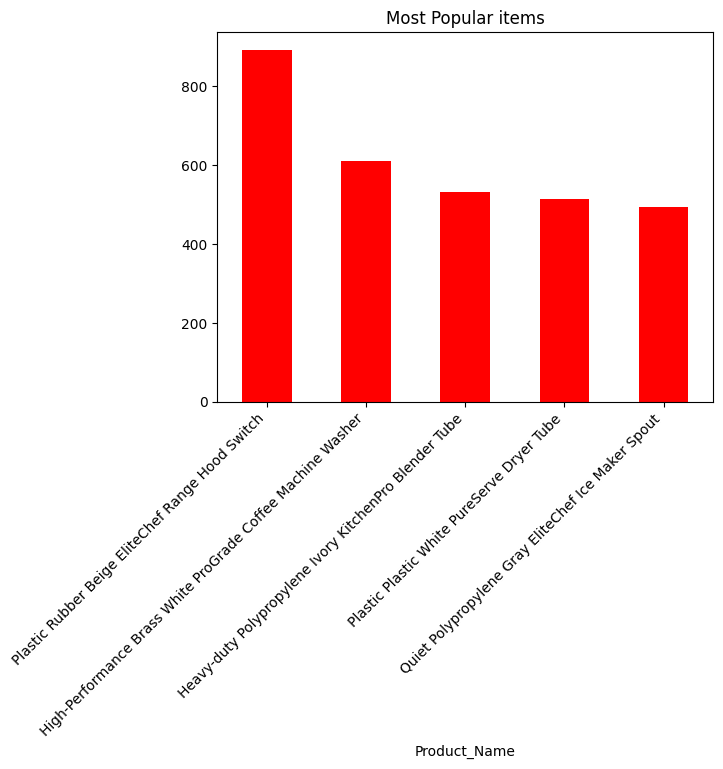

In [11]:
#Plot most popular items
popular_items = df['Product_Name'].value_counts().head(5)
popular_items.plot(kind='bar',color='red')
plt.xticks(rotation=45, ha='right')  
plt.title("Most Popular items")

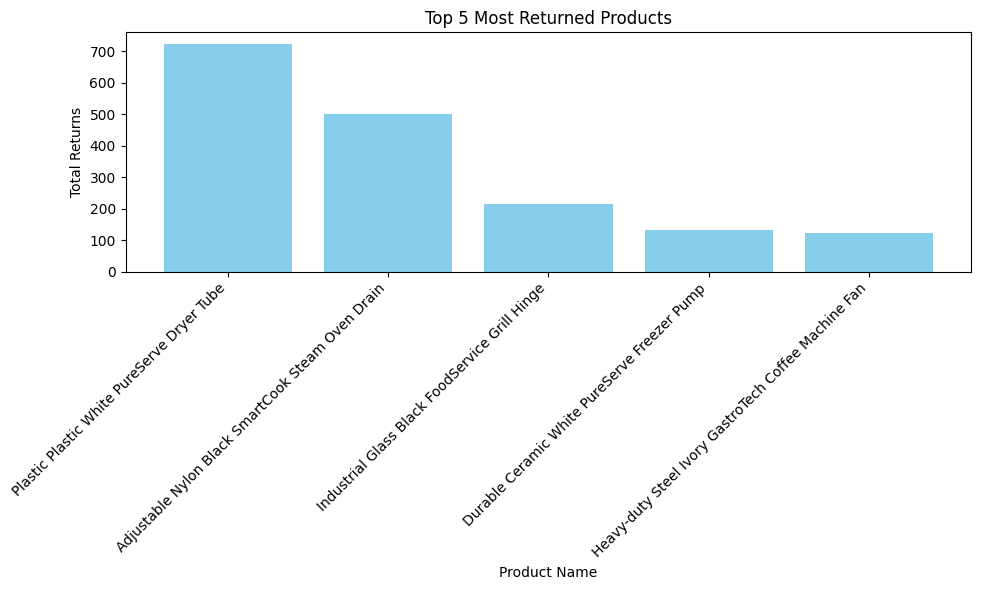

In [12]:
#Plot most returned items
returns_df = df[df['Sales_Order_Quantity'] < 0]

returned_df = returns_df.groupby(['CUSTOMER_ID', 'Product_Name']).agg({
    'Sales_Order_Quantity': 'sum',  
}).reset_index()

returned_df.rename(columns={'Sales_Order_Quantity': 'Returns'}, inplace=True)
returned_df['Returns'] = returned_df['Returns'].abs()

top_returned_products = returned_df.groupby('Product_Name')['Returns'].sum().reset_index()
top_returned_products = top_returned_products.sort_values(by='Returns', ascending=False).head(5)

plt.figure(figsize=(10, 6))
plt.bar(top_returned_products['Product_Name'], top_returned_products['Returns'], color='skyblue')

plt.xlabel('Product Name')
plt.ylabel('Total Returns')
plt.title('Top 5 Most Returned Products')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()

In [13]:
#Grouping by customer_id 
result_df = df.groupby(['CUSTOMER_ID', 'Product_Name', 'Purchase_or_Return'], as_index=False).agg({
    'Sales_Order_Quantity': 'sum',
    'Single_Margin': 'mean'        
})

result_df.rename(columns={'Sales_Order_Quantity': 'Total_Quantity'}, inplace=True)
result_df.head()

#Check returns
#result_df[result_df['Purchase_or_Return'] == 'Return']

,CUSTOMER_ID,Product_Name,Purchase_or_Return,Total_Quantity,Single_Margin
0,000b7a1d0f8cbd0403d097dc8acf6732,Adjustable Glass Green BrandC Steam Oven Nozzle,Purchase,1.0,8.46
1,000b7a1d0f8cbd0403d097dc8acf6732,Adjustable Silicone Ivory ChefMaster Mixer Seal,Purchase,2.0,73.83
2,000b7a1d0f8cbd0403d097dc8acf6732,Adjustable Stainless Steel Gray BrandB Microwa...,Purchase,1.0,4.96
3,000b7a1d0f8cbd0403d097dc8acf6732,Compact Brass Orange ChefMaster Pizza Oven She...,Purchase,3.0,49.60
4,000b7a1d0f8cbd0403d097dc8acf6732,Compact Plastic Red EliteChef Microwave Motor,Purchase,5.0,4.04


In [14]:
#Create weighted values that combine purchase count and profit margin and penalize returns
alpha = 0.6  
beta = 0.4   
penalty_factor = 0.3

result_df['Weighted_Rating'] = np.where(
    result_df['Purchase_or_Return'] == 'Return',
    (alpha * result_df['Total_Quantity'] + beta * result_df['Single_Margin']) * penalty_factor,
    alpha * result_df['Total_Quantity'] + beta * result_df['Single_Margin']
)
result_df.head()

,CUSTOMER_ID,Product_Name,Purchase_or_Return,Total_Quantity,Single_Margin,Weighted_Rating
0,000b7a1d0f8cbd0403d097dc8acf6732,Adjustable Glass Green BrandC Steam Oven Nozzle,Purchase,1.0,8.46,3.984
1,000b7a1d0f8cbd0403d097dc8acf6732,Adjustable Silicone Ivory ChefMaster Mixer Seal,Purchase,2.0,73.83,30.732
2,000b7a1d0f8cbd0403d097dc8acf6732,Adjustable Stainless Steel Gray BrandB Microwa...,Purchase,1.0,4.96,2.584
3,000b7a1d0f8cbd0403d097dc8acf6732,Compact Brass Orange ChefMaster Pizza Oven She...,Purchase,3.0,49.60,21.640
4,000b7a1d0f8cbd0403d097dc8acf6732,Compact Plastic Red EliteChef Microwave Motor,Purchase,5.0,4.04,4.616


In [15]:
#Encode customer id & products to numerical indices
customer_encoder = LabelEncoder()
product_encoder = LabelEncoder()

result_df['Customer_Index'] = customer_encoder.fit_transform(result_df['CUSTOMER_ID'])
result_df['Product_Index'] = product_encoder.fit_transform(result_df['Product_Name'])
result_df.head()

,CUSTOMER_ID,Product_Name,Purchase_or_Return,Total_Quantity,Single_Margin,Weighted_Rating,Customer_Index,Product_Index
0,000b7a1d0f8cbd0403d097dc8acf6732,Adjustable Glass Green BrandC Steam Oven Nozzle,Purchase,1.0,8.46,3.984,0,1629
1,000b7a1d0f8cbd0403d097dc8acf6732,Adjustable Silicone Ivory ChefMaster Mixer Seal,Purchase,2.0,73.83,30.732,0,3211
2,000b7a1d0f8cbd0403d097dc8acf6732,Adjustable Stainless Steel Gray BrandB Microwa...,Purchase,1.0,4.96,2.584,0,3413
3,000b7a1d0f8cbd0403d097dc8acf6732,Compact Brass Orange ChefMaster Pizza Oven She...,Purchase,3.0,49.60,21.640,0,4324
4,000b7a1d0f8cbd0403d097dc8acf6732,Compact Plastic Red EliteChef Microwave Motor,Purchase,5.0,4.04,4.616,0,6141


In [16]:
pivot_df = result_df.pivot_table(
    index='CUSTOMER_ID',      
    columns='Product_Name',     
    values='Weighted_Rating',   
    fill_value=0               
)

pivot_df.head()

Product_Name,Adjustable Aluminum Beige BrandA Steam Oven Faucet,Adjustable Aluminum Beige ChefMaster Deep Fryer Bracket,Adjustable Aluminum Beige ChefMaster Mixer Knob,Adjustable Aluminum Beige CoolTemp Oven Fan,Adjustable Aluminum Beige CoolTemp Steam Oven Washer,Adjustable Aluminum Beige EliteChef Grill Latch,Adjustable Aluminum Beige EliteChef Ice Maker Heater,Adjustable Aluminum Beige FoodService Dishwasher Thermostat,Adjustable Aluminum Beige KitchenPro Espresso Machine Nozzle,Adjustable Aluminum Beige KitchenPro Grill Bracket,...,Waterproof Steel Yellow FoodService Water Heater Clamp,Waterproof Steel Yellow GastroTech Steam Oven Fan,Waterproof Steel Yellow HeatWave Deep Fryer Handle,Waterproof Steel Yellow KitchenPro Convection Oven Heater,Waterproof Steel Yellow PureServe Ice Maker Washer,Waterproof Steel Yellow QuickSeal Mixer Nozzle,Waterproof Steel Yellow QuickSeal Mixer Thermostat,Waterproof Steel Yellow SmartCook Dryer Seal,Waterproof Steel Yellow SteelForce Oven Pump,Waterproof Steel Yellow SteelForce Refrigerator Pump
CUSTOMER_ID,,,,,,,,,,,,,,,,,,,,,
000b7a1d0f8cbd0403d097dc8acf6732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001f3028b94c2406e7b7c7d1d55ef743,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
003c036a082a54d9d4a8c02704a9b01d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
004bd284af1b1f329213876fcb4debf3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
005b26ee33b3fd1d7fe307ca022b095b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
#Download pivot data
copy_pivot_df = pivot_df.head(25)
file_path = '/Users/danayou/Desktop/DS-Case-Study/data/pivot.csv'
copy_pivot_df.to_csv(file_path, index=False)

In [24]:
#Download original data
copy_df = df.head(25)
file_path = '/Users/danayou/Desktop/DS-Case-Study/data/sample.csv'
copy_df.to_csv(file_path, index=False)

In [18]:
#Create user-item matrix
csr = csr_matrix(pivot_df.values)
print(csr)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 367382 stored elements and shape (2326, 97073)>
  Coords	Values
  (0, 1629)	3.9840000000000004
  (0, 3211)	30.732
  (0, 3413)	2.584
  (0, 4324)	21.640000000000004
  (0, 6141)	4.616
  (0, 11691)	10.952
  (0, 13389)	8.112
  (0, 13574)	18.936
  (0, 14466)	39.028
  (0, 16175)	12.664
  (0, 16237)	2.452
  (0, 18178)	18.608000000000004
  (0, 19077)	14.336000000000002
  (0, 19227)	3.284
  (0, 19312)	1.6760000000000002
  (0, 20018)	66.5
  (0, 21743)	3.9560000000000004
  (0, 22286)	12.84
  (0, 23045)	30.128
  (0, 23601)	40.652
  (0, 26816)	42.208000000000006
  (0, 27309)	61.98
  (0, 29263)	2.588
  (0, 30347)	5.056
  (0, 30680)	5.088
  :	:
  (2325, 71289)	2.7319999999999998
  (2325, 71996)	10.096
  (2325, 72049)	4.18
  (2325, 73803)	29.264
  (2325, 74435)	3.8359999999999994
  (2325, 74743)	3.904
  (2325, 76091)	7.008
  (2325, 76563)	27.904000000000003
  (2325, 76611)	3.3920000000000003
  (2325, 77283)	16.836000000000002
  (2325, 77961)

In [19]:
#Calculate matrix sparsity
total_elements = csr.shape[0] * csr.shape[1]
non_zero_elements = csr.nnz  
sparsity = (non_zero_elements / total_elements) * 100

print(f"{sparsity}%")

0.16270830174265233%


In [25]:
#Find best parameters using grid search
def explained_variance_scorer(estimator, X, y=None):
    estimator.fit(X)
    return np.sum(estimator.explained_variance_ratio_)  # Cumulative explained variance

param_grid = {
    'n_components': [400, 500, 600],  
    'algorithm': ['randomized', 'arpack']
}

svd = TruncatedSVD()

grid_search = GridSearchCV(svd, param_grid, cv=5, scoring=explained_variance_scorer)
grid_search.fit(csr)

print("Best Parameters:", grid_search.best_params_)

/Users/danayou/Desktop/DS-Case-Study/myenv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/danayou/Desktop/DS-Case-Study/myenv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/4b/g57nhlh500n51njz9g6jjb8m0000gn/T/ipykernel_51033/3139207648.py", line 3, in explained_variance_scorer
    estimator.fit(X)
  File "/Users/danayou/Desktop/DS-Case-Study/myenv/lib/python3.12/site-packages/sklearn/decomposition/_truncated_svd.py", line 208, in fit
    self.fit_transform(X)
  File "/Users/danayou/Desktop/DS-Case-Study/myenv/lib/python3.12/site-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args

Best Parameters: {'algorithm': 'randomized', 'n_components': 500}


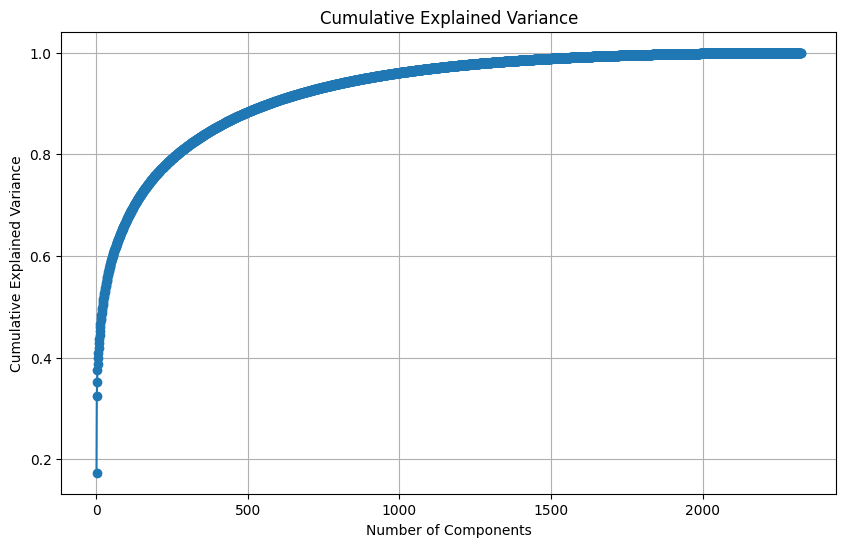

In [26]:
#Plot cumulative explained variance and number of components
svd = TruncatedSVD(n_components=min(csr.shape)-1)  
svd.fit(csr)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(svd.explained_variance_ratio_) + 1), svd.explained_variance_ratio_.cumsum(), marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

In [27]:
#Matrix factorization
n_components = 500  
svd = TruncatedSVD(n_components=n_components, random_state=42)

user_features = svd.fit_transform(csr)
item_features = svd.components_

predicted_ratings = np.dot(user_features, item_features)

predicted_df = pd.DataFrame(predicted_ratings, index=pivot_df.index, columns=pivot_df.columns)
predicted_df.head()

Product_Name,Adjustable Aluminum Beige BrandA Steam Oven Faucet,Adjustable Aluminum Beige ChefMaster Deep Fryer Bracket,Adjustable Aluminum Beige ChefMaster Mixer Knob,Adjustable Aluminum Beige CoolTemp Oven Fan,Adjustable Aluminum Beige CoolTemp Steam Oven Washer,Adjustable Aluminum Beige EliteChef Grill Latch,Adjustable Aluminum Beige EliteChef Ice Maker Heater,Adjustable Aluminum Beige FoodService Dishwasher Thermostat,Adjustable Aluminum Beige KitchenPro Espresso Machine Nozzle,Adjustable Aluminum Beige KitchenPro Grill Bracket,...,Waterproof Steel Yellow FoodService Water Heater Clamp,Waterproof Steel Yellow GastroTech Steam Oven Fan,Waterproof Steel Yellow HeatWave Deep Fryer Handle,Waterproof Steel Yellow KitchenPro Convection Oven Heater,Waterproof Steel Yellow PureServe Ice Maker Washer,Waterproof Steel Yellow QuickSeal Mixer Nozzle,Waterproof Steel Yellow QuickSeal Mixer Thermostat,Waterproof Steel Yellow SmartCook Dryer Seal,Waterproof Steel Yellow SteelForce Oven Pump,Waterproof Steel Yellow SteelForce Refrigerator Pump
CUSTOMER_ID,,,,,,,,,,,,,,,,,,,,,
000b7a1d0f8cbd0403d097dc8acf6732,-0.001904,0.008838,-0.004071,-0.000066,-0.153764,0.002203,-0.000604,-0.020970,0.006829,0.205854,...,-0.010596,-0.000459,-0.007749,-0.016478,0.011127,0.001131,0.071854,-0.008558,0.035826,-0.001631
001f3028b94c2406e7b7c7d1d55ef743,-0.010603,-0.006179,0.020022,-0.000218,0.133168,-0.009803,-0.002064,-0.063935,0.282530,0.666730,...,-0.086904,-0.003483,0.007256,0.213284,0.002220,0.058810,0.163668,-0.038271,-0.040043,-0.009774
003c036a082a54d9d4a8c02704a9b01d,0.003588,0.094372,-0.003448,0.000062,-0.128409,-0.004061,0.001337,0.286849,-0.105704,-0.346957,...,-0.056860,0.017777,0.028248,-0.041474,0.005346,0.092991,-0.109879,-0.157279,0.013727,-0.001261
004bd284af1b1f329213876fcb4debf3,-0.023450,-0.051716,0.021596,-0.000793,0.068310,0.026448,-0.001927,0.012439,0.087536,-0.062945,...,-0.065609,0.002004,-0.016029,0.023360,0.005784,0.145772,0.298621,-0.006581,0.076506,0.002324
005b26ee33b3fd1d7fe307ca022b095b,0.045488,0.034419,-0.009098,0.000080,-0.076691,-0.012247,-0.001324,-0.126547,-0.064528,0.073413,...,0.005339,0.003456,0.015190,-0.004887,-0.001438,-0.199757,0.014096,-0.014885,0.012375,0.000118


In [28]:
#Generate recommendations
def get_recommendations(user_id, num_recommendations=5):
    user_row = predicted_df.loc[user_id]
    unrated_products = pivot_df.loc[user_id] == 0
    recommended_products = user_row[unrated_products].sort_values(ascending=False)

    return recommended_products.head(num_recommendations)

get_recommendations('f65441a4f5d7b872ea428bdc27359061')

Product_Name
Industrial Plastic Ivory SmartCook Mixer Bushing                 5.955160
Energy-Efficient Fiber Yellow GastroTech Coffee Machine Drain    5.292978
Industrial Plastic Beige SteelForce Mixer Tube                   4.108210
Corrosion-Resistant Plastic Green BrandA Freezer Coupling        4.028567
Energy-Efficient Fiber Transparent EliteChef Dryer Spout         3.982436
Name: f65441a4f5d7b872ea428bdc27359061, dtype: float64